# 🎯**Создание набора данных из изображений  и обучение сверточной нейронной сети**
## Задания:
## 1 - научиться создавать наборы данных из изображений
## 2 - создать свой набор данных (из изображений из открытых источников) и обучить нейронную сеть
## 3 - создать свой набор данных (из изображений полученных самостоятельно) и обучить нейронную сеть

## добавление необходимых модулей

In [41]:
import os
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torchvision

import random
from torchvision import transforms, models
import torch.nn.functional as F

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## добавление трансформаций

In [42]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


valid_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## добавление путей к наборам данных

In [43]:
train_path = '/content/drive/MyDrive/Colab Notebooks/dataset_transport2/train'
test_path = '/content/drive/MyDrive/Colab Notebooks/dataset_transport2/test'
valid_path = '/content/drive/MyDrive/Colab Notebooks/dataset_transport2/valid'
n_classes=5

## создание наборов данных
### необходимо изображения разложить по папкам:
### - название папки - соответствует названию класса
### - в каждой папке изображения соответсвующего класса


In [44]:
train_dataset = torchvision.datasets.ImageFolder(train_path, train_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_path, test_transforms)
valid_dataset = torchvision.datasets.ImageFolder(valid_path, valid_transforms)

## создание загрузчиков данных

In [45]:
batch_size = 10
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [46]:
len(train_dataloader), len(train_dataset), len(test_dataset), len(valid_dataset), len(test_dataloader)

(29, 285, 148, 254, 26)

## анализ данных

TURBERCULOSIS


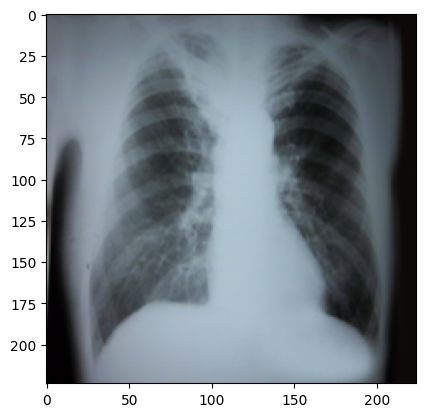

In [47]:
X, y = next(iter(train_dataloader))
for i in range(batch_size//10):
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  print(train_dataset.classes[y[i]])
  plt.imshow(X[i].permute(1,2,0).numpy() * std + mean)
  plt.show()


## функция обучения модели нейронной сети

In [48]:
def train(model, optimizer, loss_fn, train_loader, valid_loader, n_epochs=10, device='cpu'):

    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        train_num_correct = 0
        train_num_examples = 0
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            train_num_correct += torch.sum(correct).item()
            train_num_examples += correct.shape[0]
        train_loss /= len(train_dataloader.dataset)

        model.eval()
        valid_num_correct = 0
        valid_num_examples = 0
        for batch in valid_dataloader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output, targets)
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            valid_num_correct += torch.sum(correct).item()
            valid_num_examples += correct.shape[0]
        valid_loss /= len(valid_loader.dataset)

        print('Epoch: {}, train loss: {:.2f}, valid loss: {:.2f},train accuracy: {:.2f}, valid accuracy: {:.2f}'\
              .format(epoch, train_loss, valid_loss, train_num_correct / train_num_examples, valid_num_correct / valid_num_examples))

## функция тестирования модели нейронной сети

In [49]:
def test(model,test_dataloader):
    model.eval()
    num_correct = 0
    num_examples = 0
    for batch in test_dataloader:
        inputs, targets = batch
        inputs = inputs.to(device)
        output = model(inputs)
        targets = targets.to(device)
        correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]

    print('accuracy: {:.2f}'.format(num_correct/num_examples))


## создание модели нейронной сети

In [50]:
#model = models.resnet18(pretrained=True)

model = models.shufflenet_v2_x0_5(pretrained=True)
# Disable grad for all conv layers
#for param in model.parameters():
 #   param.requires_grad = False


#model.fc = torch.nn.Linear(model.fc.in_features, n_classes)
model.fc = torch.nn.Sequential(torch.nn.Linear(model.fc.in_features,model.fc.in_features), torch.nn.Tanh(), torch.nn.Dropout(), torch.nn.Linear(model.fc.in_features,n_classes))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## обучение модели нейронной сети

In [51]:
train(model, optimizer, loss_fn, train_dataloader, valid_dataloader)

Epoch: 1, train loss: 1.03, valid loss: 0.86,train accuracy: 0.61, valid accuracy: 0.70
Epoch: 2, train loss: 0.39, valid loss: 0.28,train accuracy: 0.86, valid accuracy: 0.89
Epoch: 3, train loss: 0.14, valid loss: 0.32,train accuracy: 0.95, valid accuracy: 0.88
Epoch: 4, train loss: 0.11, valid loss: 0.21,train accuracy: 0.96, valid accuracy: 0.93
Epoch: 5, train loss: 0.10, valid loss: 0.49,train accuracy: 0.97, valid accuracy: 0.85
Epoch: 6, train loss: 0.08, valid loss: 0.25,train accuracy: 0.97, valid accuracy: 0.93
Epoch: 7, train loss: 0.11, valid loss: 0.30,train accuracy: 0.97, valid accuracy: 0.92
Epoch: 8, train loss: 0.03, valid loss: 0.26,train accuracy: 0.99, valid accuracy: 0.91
Epoch: 9, train loss: 0.06, valid loss: 0.33,train accuracy: 0.98, valid accuracy: 0.90
Epoch: 10, train loss: 0.03, valid loss: 0.39,train accuracy: 0.99, valid accuracy: 0.89


## тестирование модели нейронной сети

In [52]:
test(model,test_dataloader)

<ipython-input-49-77a5e86197b1>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets)


accuracy: 0.89


## анализ результатов

y*= COVID19 , y= COVID19


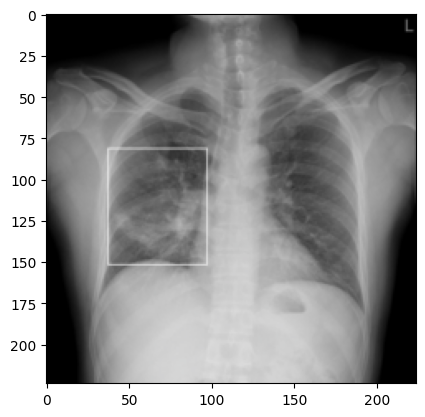

y*= PNEUMONIA , y= PNEUMONIA


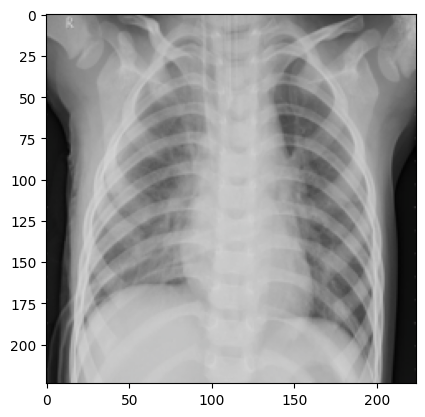

y*= NORMAL , y= NORMAL


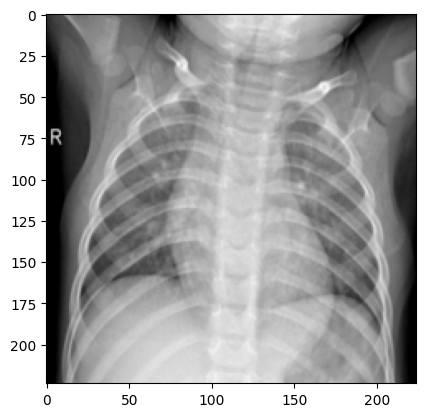

y*= TURBERCULOSIS , y= TURBERCULOSIS


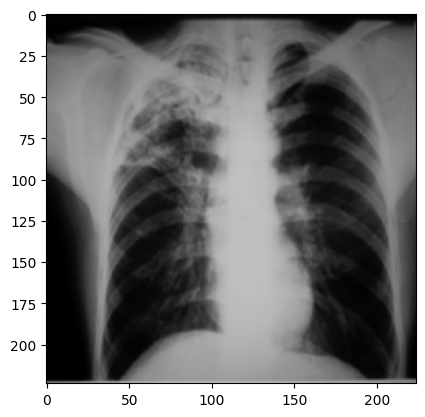

y*= TURBERCULOSIS , y= TURBERCULOSIS


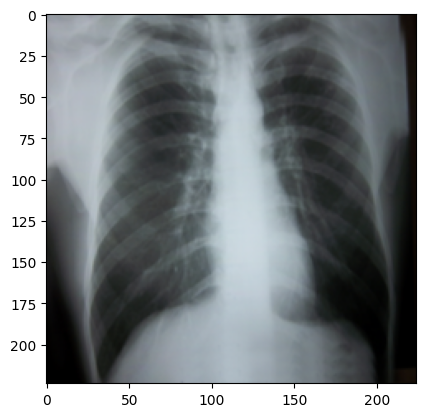

y*= PNEUMONIA , y= PNEUMONIA


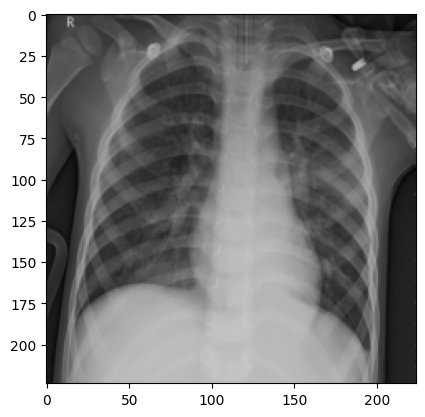

y*= PNEUMONIA , y= PNEUMONIA


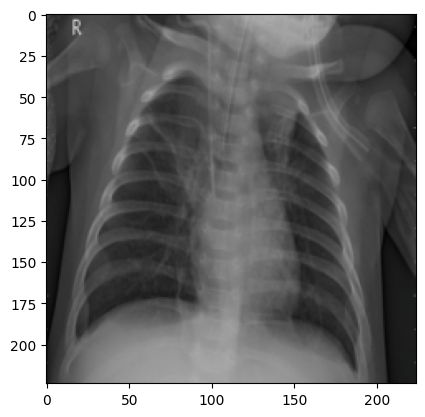

y*= COVID19 , y= COVID19


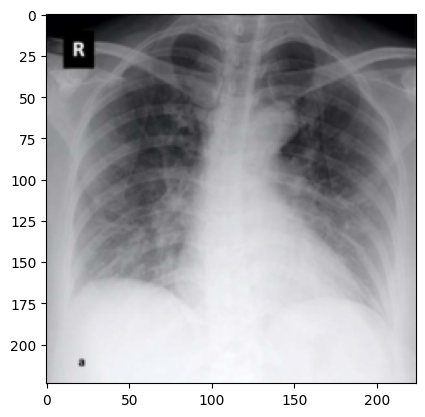

y*= TURBERCULOSIS , y= TURBERCULOSIS


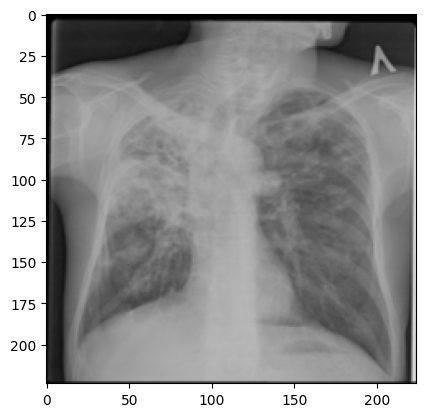

y*= COVID19 , y= COVID19


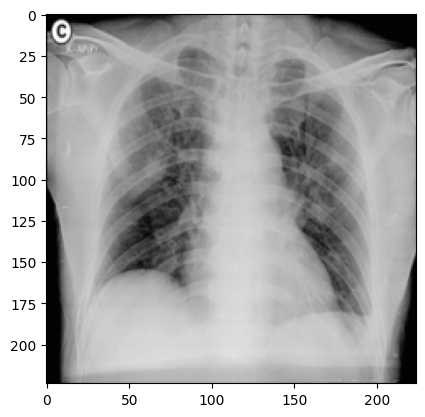

In [53]:
X, y = next(iter(test_dataloader))
output = model(X.to(device))

for i in range(batch_size):
  _, predicted = torch.max(output.data, 1)
  print('y*=',train_dataset.classes[predicted[i]], ', y=',train_dataset.classes[y[i]])
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  plt.imshow(X[i].permute(1, 2, 0).numpy() * std + mean)
  plt.show()